### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# Importing plot libs
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### Reading Dataset

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('imdb_data.csv')

### EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3348 entries, 0 to 3347
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              3348 non-null   object 
 1   primaryTitle    3348 non-null   object 
 2   originalTitle   3348 non-null   object 
 3   isAdult         3348 non-null   int64  
 4   runtimeMinutes  3348 non-null   int64  
 5   genres          3348 non-null   object 
 6   averageRating   3348 non-null   float64
 7   numVotes        3348 non-null   int64  
 8   budget          3348 non-null   int64  
 9   gross           3297 non-null   float64
 10  release_date    3343 non-null   object 
 11  directors       3348 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 314.0+ KB


In [4]:
df.head()

,id,primaryTitle,originalTitle,isAdult,runtimeMinutes,genres,averageRating,numVotes,budget,gross,release_date,directors
0,tt0035423,Kate & Leopold,Kate & Leopold,0,118,"Comedy,Fantasy,Romance",6.4,87925,48000000,76019048.0,"December 11, 2001",James Mangold
1,tt0065421,The Aristocats,The AristoCats,0,78,"Adventure,Animation,Comedy",7.1,111758,4000000,35459543.0,"December 11, 1970",Wolfgang Reitherman
2,tt0065938,Kelly's Heroes,Kelly's Heroes,0,144,"Adventure,Comedy,War",7.6,52628,4000000,5200000.0,"January 1, 1970",Brian G. Hutton
3,tt0066026,M*A*S*H,M*A*S*H,0,116,"Comedy,Drama,War",7.4,75784,3500000,81600000.0,"January 25, 1970",Robert Altman
4,tt0066206,Patton,Patton,0,172,"Biography,Drama,War",7.9,106476,12000000,61749765.0,"February 4, 1970",Franklin J. Schaffner


In [5]:
df.duplicated().sum()

0

In [6]:
(df
 .isna()
 .sum()
 .sort_values(ascending=False)
 .reset_index()
 .rename(columns = {'index' : "Column", 0 : "Missing"})
)

,Column,Missing
0,gross,51
1,release_date,5
2,id,0
3,primaryTitle,0
4,originalTitle,0
5,isAdult,0
6,runtimeMinutes,0
7,genres,0
8,averageRating,0
9,numVotes,0


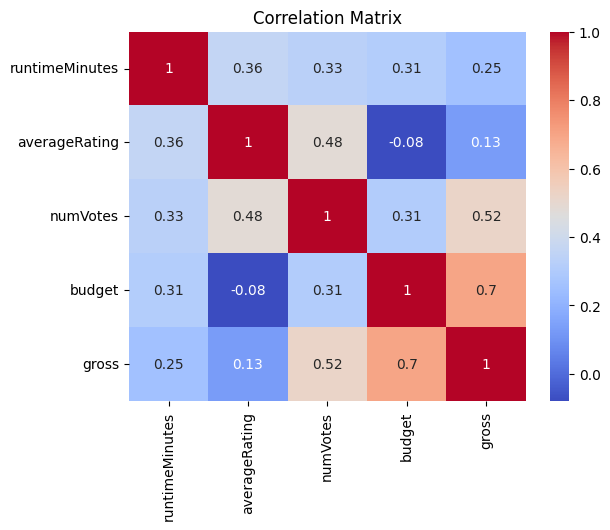

In [7]:
numeric = ['runtimeMinutes', 'averageRating', 'numVotes', 'budget', 'gross']
corr_matrix = df[numeric].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix');

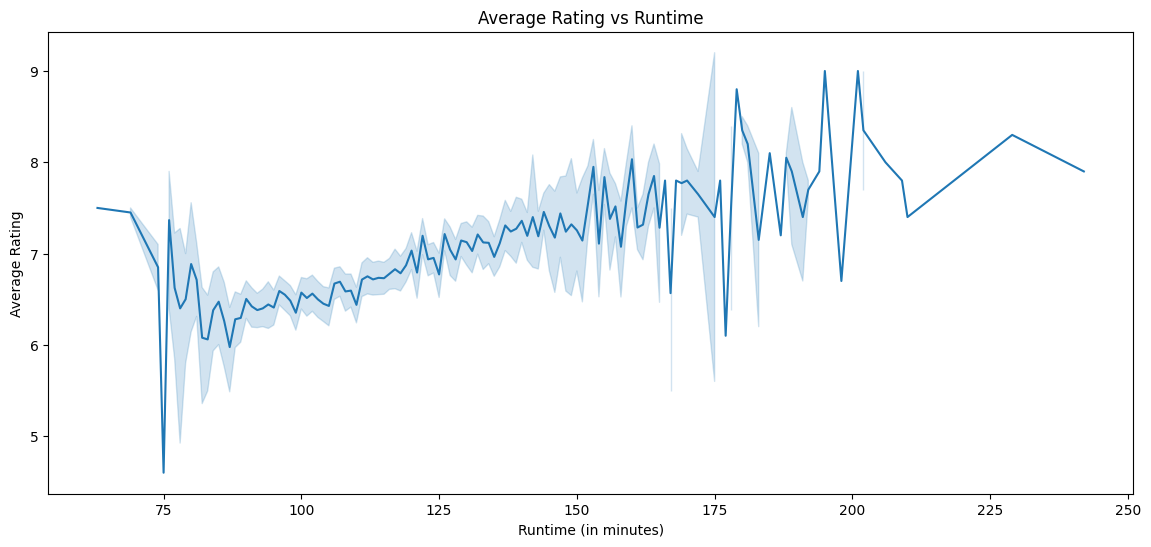

In [8]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(x='runtimeMinutes', y='averageRating', data=df);
plt.title('Average Rating vs Runtime');
plt.xlabel('Runtime (in minutes)')
plt.ylabel('Average Rating');

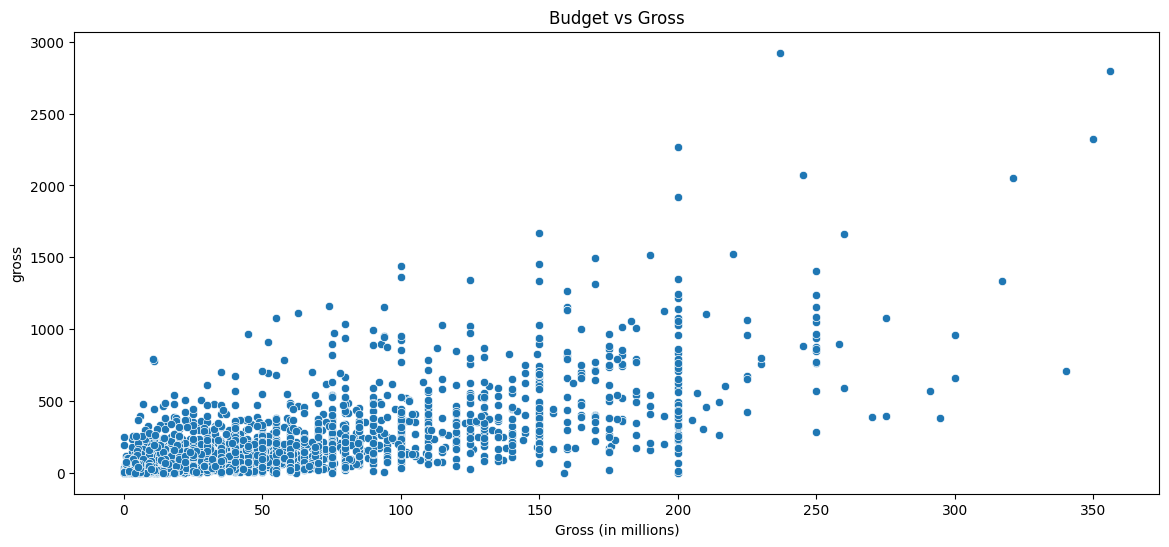

In [9]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.scatterplot(x='budget', y='gross', data=df, ax=ax);
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x/1e6)}')
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
plt.title('Budget vs Gross')
plt.xlabel('Budget (in millions)')
plt.xlabel('Gross (in millions)');

### Encoding

In [10]:
df['genres'] = df['genres'].str.split(',')

In [11]:
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df['genres'])
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)


In [12]:
df = pd.concat([df, genres_df], axis=1)
df[mlb.classes_] = df[mlb.classes_].fillna(0)
df.drop('genres', axis=1, inplace=True)
df.dropna(inplace=True)


In [13]:
for column in mlb.classes_:
    df[column] = df[column].astype(int)
    df.rename(columns={column: column.lower()}, inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3292 entries, 0 to 3347
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              3292 non-null   object 
 1   primaryTitle    3292 non-null   object 
 2   originalTitle   3292 non-null   object 
 3   isAdult         3292 non-null   int64  
 4   runtimeMinutes  3292 non-null   int64  
 5   averageRating   3292 non-null   float64
 6   numVotes        3292 non-null   int64  
 7   budget          3292 non-null   int64  
 8   gross           3292 non-null   float64
 9   release_date    3292 non-null   object 
 10  directors       3292 non-null   object 
 11  action          3292 non-null   int32  
 12  adventure       3292 non-null   int32  
 13  animation       3292 non-null   int32  
 14  biography       3292 non-null   int32  
 15  comedy          3292 non-null   int32  
 16  crime           3292 non-null   int32  
 17  documentary     3292 non-null   int32 

In [15]:
df.head()

,id,primaryTitle,originalTitle,isAdult,runtimeMinutes,averageRating,numVotes,budget,gross,release_date,directors,action,adventure,animation,biography,comedy,crime,documentary,drama,family,fantasy,history,horror,music,musical,mystery,news,romance,sci-fi,sport,thriller,war,western
0,tt0035423,Kate & Leopold,Kate & Leopold,0,118,6.4,87925,48000000,76019048.0,"December 11, 2001",James Mangold,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1,tt0065421,The Aristocats,The AristoCats,0,78,7.1,111758,4000000,35459543.0,"December 11, 1970",Wolfgang Reitherman,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,tt0065938,Kelly's Heroes,Kelly's Heroes,0,144,7.6,52628,4000000,5200000.0,"January 1, 1970",Brian G. Hutton,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,tt0066026,M*A*S*H,M*A*S*H,0,116,7.4,75784,3500000,81600000.0,"January 25, 1970",Robert Altman,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,tt0066206,Patton,Patton,0,172,7.9,106476,12000000,61749765.0,"February 4, 1970",Franklin J. Schaffner,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Features / Target

In [16]:
FEATURES = ['isAdult', 'runtimeMinutes', 'numVotes', 'budget', 'gross', 'action', 
     'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 
     'drama', 'family', 'fantasy', 'history', 'horror', 'music', 
     'musical', 'mystery', 'news', 'romance', 'sci-fi', 'sport', 
     'thriller', 'war', 'western']
TARGET = ['averageRating']

### Train / Validation / Test

In [17]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df[FEATURES], df[TARGET], test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size= 0.2, random_state=42)

### Scaling

In [18]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [19]:
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [20]:
min_value = np.min(y_train)
max_value = np.max(y_train)

y_train = (y_train - min_value) / (max_value - min_value)
y_test = (y_test - min_value) / (max_value - min_value)
y_val = (y_val - min_value) / (max_value - min_value)

In [21]:
len(X_train), len(X_val), len(X_test)

(2238, 560, 494)

### Cross-Validation

In [22]:
!pip install -q lightgbm

In [23]:
import lightgbm as lgbm

In [24]:
lr = LinearRegression()
cv_lr = cross_validate(lr, df[FEATURES], df[TARGET], cv=5, scoring='r2')

In [25]:
print('LinearRegression\n')
print('Average Score: ', np.mean(cv_lr['test_score']))
print('Std: ', np.std(cv_lr['test_score']))

LinearRegression

Average Score:  0.4009662249933653
Std:  0.12321083043206249


In [26]:
lg = lgbm.LGBMRegressor(verbose=-1)
cv_lg = cross_validate(lg, df[FEATURES], df[TARGET], cv=5, scoring='r2')

In [27]:
print('LightGBM\n')
print('Average Score: ', np.mean(cv_lg['test_score']))
print('Std: ', np.std(cv_lg['test_score']))

LightGBM

Average Score:  0.5391667743684204
Std:  0.10142275493814046


In [28]:
y = df[TARGET].values.ravel()
rf = RandomForestRegressor()
cv_rf = cross_validate(rf, df[FEATURES], y, cv=5, scoring='r2')

In [29]:
print('RandomForest\n')
print('Average Score: ', np.mean(cv_rf['test_score']))
print('Std: ', np.std(cv_rf['test_score']))

RandomForest

Average Score:  0.507814393911932
Std:  0.1149641251692723


### Hyperparameter Tuning

In [30]:
def perform_gs(model, param_grid, X, y, scoring, refit='r2'):
    gs = GridSearchCV(model, param_grid=param_grid, cv=5, scoring=scoring, n_jobs=-1, verbose=10, refit=refit)
    gs.fit(df[FEATURES], df[TARGET])
    best_model = gs.best_estimator_
    best_params = gs.best_params_
    best_score = gs.best_score_
    return best_model, best_params, best_score

scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'r2': make_scorer(r2_score)
}

### LinearRegression

In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_val)

In [32]:
lr_r2 = r2_score(y_val, lr_pred)
print(f'R2: {lr_r2}')

R2: 0.5046260022068387


### LightGBM

In [33]:
lg = lgbm.LGBMRegressor(verbose=-1)
params = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [-1, 3, 5, 10],
}

In [34]:
best_model, best_params, best_score = perform_gs(lg, params, X_train, y_train, scoring)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [35]:
print(f'Best params: {best_params}')
print(f'Best R2', {best_score})

Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
Best R2 {0.5533049383823277}


### RandomForest

In [36]:
rf = RandomForestRegressor()
params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 12],
}

In [37]:
best_model, best_params, best_score = perform_gs(rf, params, X_train, y_train, scoring)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [38]:
print(f'Best params: {best_params}')
print(f'Best R2', {best_score})

Best params: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 200}
Best R2 {0.5154424591046933}


### Training a Regression Model

### LightGBM

In [39]:
lg = lgbm.LGBMRegressor(learning_rate=0.05, max_depth=3, n_estimators=300, verbose=-1)
lg.fit(X_train, y_train)
lg_pred = lg.predict(X_test)

In [40]:
lg_r2 = r2_score(y_test, lg_pred)
lg_rmse = mean_squared_error(y_test, lg_pred) ** 0.5
print(f'R2: {lg_r2}')
print(f'RMSE: {lg_rmse}')

R2: 0.6115924876502574
RMSE: 0.06679342745890965


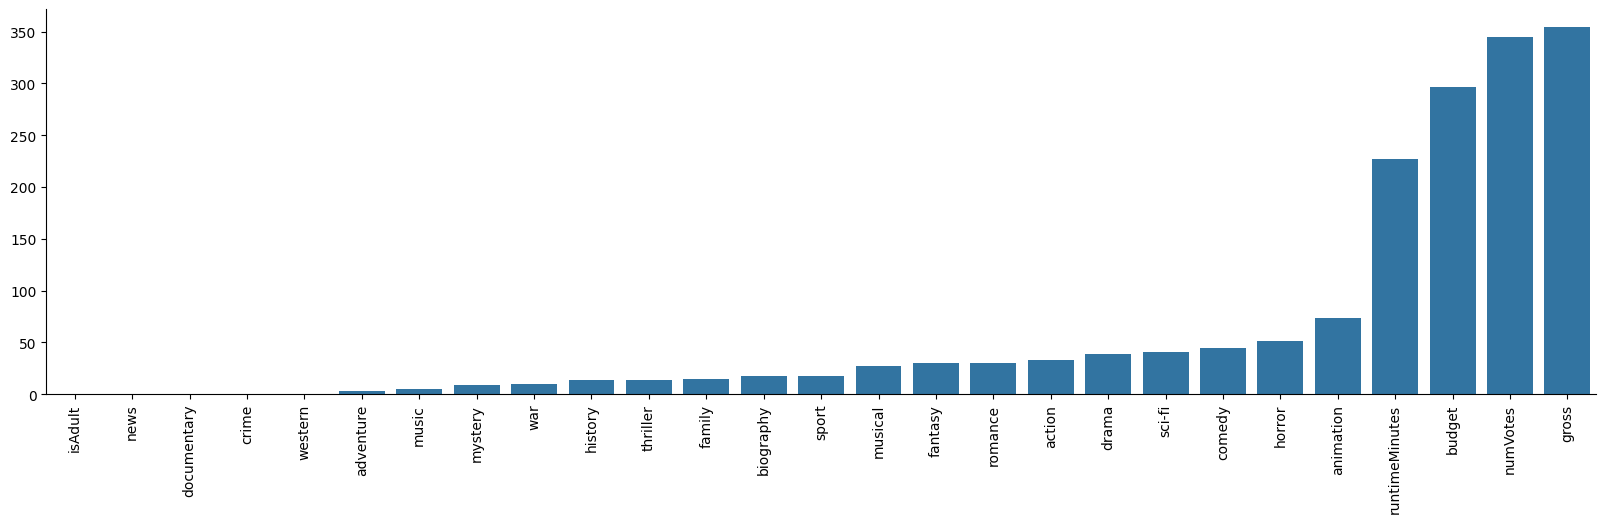

In [41]:
feature_importance = lg.feature_importances_
indexes = np.argsort(feature_importance)
sorted_features = np.array(FEATURES)[indexes]
sorted_importances = feature_importance[indexes]

fig, ax = plt.subplots(figsize = (20,5))
sns.barplot(x=sorted_features, y=sorted_importances, ax=ax)
plt.xticks(rotation = 90)
sns.despine()

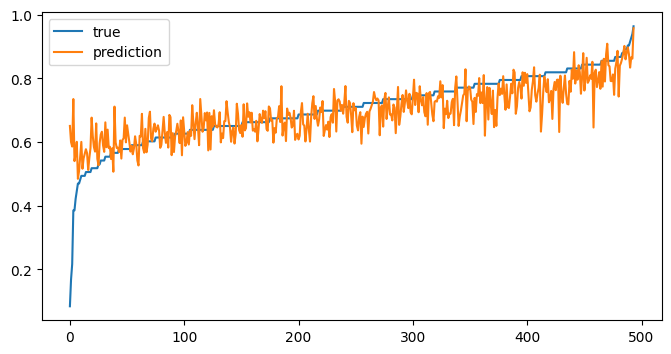

In [42]:
y_test_array = y_test.to_numpy()
indexes = np.argsort(y_test_array.flatten())

plt.figure(figsize=(8, 4))
plt.plot(y_test_array.flatten()[indexes], label='true')
plt.plot(lg_pred[indexes], label='prediction')
plt.legend();

### RandomForest

In [43]:
rf = RandomForestRegressor(max_depth=30, min_samples_split=12, n_estimators=300)
rf.fit(X_train, (y_train))
rf_pred = rf.predict(X_test)

In [44]:
rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = mean_squared_error(y_test, rf_pred) ** 0.5
print(f'R2: {rf_r2}')
print(f'RMSE: {rf_rmse}')

R2: 0.5700912559142763
RMSE: 0.07027131137061542


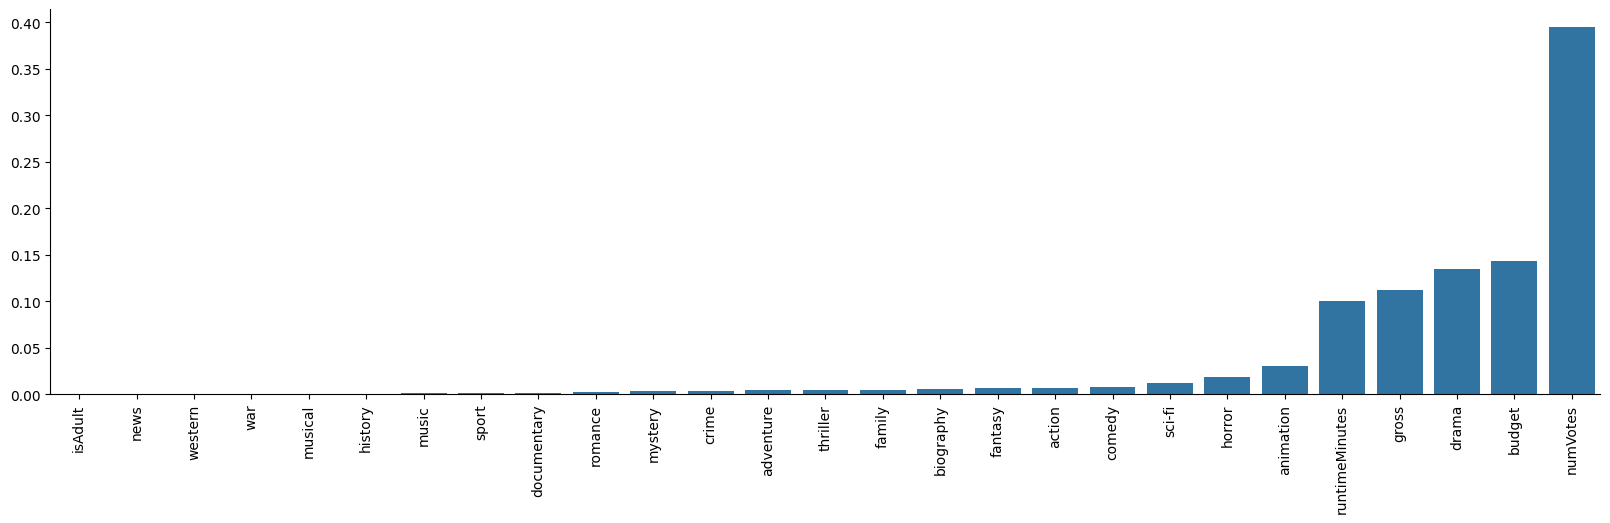

In [45]:
feature_importance = rf.feature_importances_
indexes = np.argsort(feature_importance)
features = np.array(FEATURES)

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=features[indexes], y=feature_importance[indexes], ax=ax)
plt.xticks(rotation=90)
sns.despine()

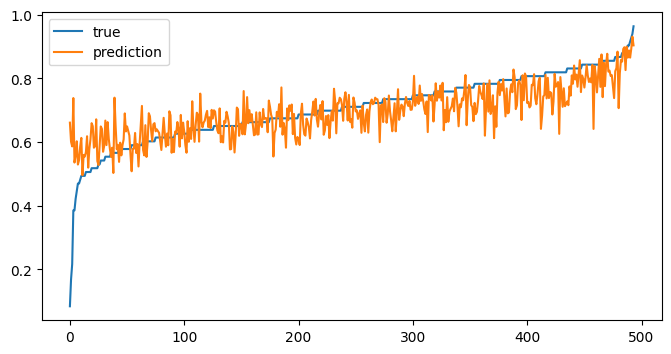

In [46]:
y_test_array = y_test.to_numpy()
indexes = np.argsort(y_test_array.flatten())

plt.figure(figsize=(8, 4))
plt.plot(y_test_array.flatten()[indexes], label='true')
plt.plot(rf_pred[indexes], label='prediction')
plt.legend();

### Conclusion

Best trained model: LightGBMRegressor.

Hyperparameters: learning_rate=0.05, max_depth=3, n_estimators=300

Scores = R2: 0.6115924876502574 / RMSE: 0.06679342745890965

Most important features: Gross, NumVotes, Budget